<a href="https://colab.research.google.com/github/rizwan1/UmarTech/blob/main/yolo_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models,regularizers

In [ ]:
# @title Default title text
# pre trained model

In [9]:
pip install opencv-python

In [10]:
!wget --quiet --show-progress -O yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget --quiet --show-progress -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget --quiet --show-progress -O coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names


yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      
yolov3.weights      100%[===================>] 236.52M  26.7MB/s    in 7.6s    
coco.names          100%[===================>]     625  --.-KB/s    in 0s      


In [11]:
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

In [21]:
with open("coco.names", "r") as f:
    class_names = f.read().strip().split("\n")

In [12]:
!wget --quiet --show-progress -O yolo_full.zip https://www.dropbox.com/scl/fi/yyyao6aapobi7ncltdq4x/yolo_data_full.zip?rlkey=xh0whl503p4ysr5mwhzhvapmy&dl=0

yolo_full.zip       100%[===================>]   3.83G  91.2MB/s    in 47s     


In [ ]:
with open("coco.names", "r") as f:
    class_names = f.read().strip().split("\n")

In [17]:
!unzip -q yolo_full.zip

replace __MACOSX/._yolo_data_full? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [22]:
def yolo_detect(image_path, net, class_names, confidence_threshold=0.5, nms_threshold=0.4):
    """Runs YOLOv3 on an image and draws detected bounding boxes."""
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Convert image to YOLO format
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get layer names
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Run forward pass
    detections = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []

    # Process detections
    for output in detections:
        for detection in output:
            scores = detection[5:]  # Object scores
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > confidence_threshold:
                # Convert YOLO format (center x, center y, width, height) to (x_min, y_min, x_max, y_max)
                center_x, center_y, w, h = (detection[:4] * [width, height, width, height]).astype("int")
                x_min, y_min = int(center_x - w / 2), int(center_y - h / 2)

                boxes.append([x_min, y_min, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

    # Draw detected objects
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image



class_names

In [ ]:
!pip install matplotlib

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


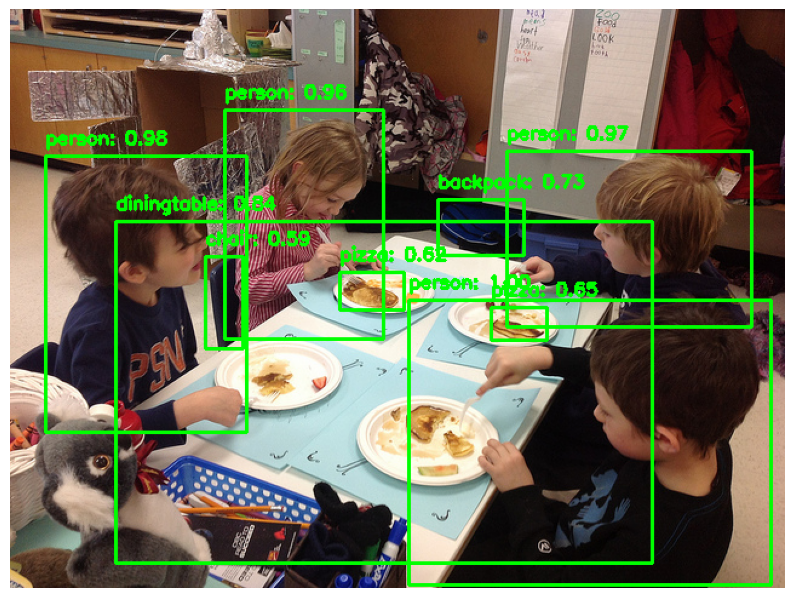

In [23]:
image_path="/content/yolo_data_full/images/000000578805.jpg"
output_image = yolo_detect(image_path, net, class_names)

# Display the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 15.5 MB/s eta 0:00:00


In [ ]:
# for video

In [24]:
!wget --quiet --show-progress -O traffic.mp4 https://www.dropbox.com/scl/fi/pz6pd1hbdywh78zby7uh5/traffic.mp4?rlkey=aqo1gdegv0gxdm1p7dvqygo56&dl=0


traffic.mp4         100%[===================>] 159.54M  90.9MB/s    in 1.8s    


In [25]:

# Open video file
input_video_path = "/content/traffic.mp4"  # Change to your video file
output_video_path = "output.mp4"

cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define video writer
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Get layer names for YOLOv3
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]




In [26]:
from google.colab.patches import cv2_imshow

In [27]:
# YOLO settings
CONFIDENCE_THRESHOLD = 0.5  # Minimum confidence to keep a detection
IOU_THRESHOLD = 0.4  # Non-Maximum Suppression threshold

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Break if video ends

    height, width, _ = frame.shape

    # Convert frame to YOLO input format
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Run YOLO inference
    detections = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []

    # Process detections
    for output in detections:
        for detection in output:
            scores = detection[5:]  # Object confidence scores
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > CONFIDENCE_THRESHOLD:
                # Convert YOLO format (center x, center y, width, height) to (x_min, y_min, x_max, y_max)
                center_x, center_y, w, h = (detection[:4] * [width, height, width, height]).astype("int")
                x_min, y_min = int(center_x - w / 2), int(center_y - h / 2)

                boxes.append([x_min, y_min, int(w), int(h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, IOU_THRESHOLD)

    # Draw detected objects
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = f"{class_names[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write frame to output video
    out.write(frame)


# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Processed video saved as {output_video_path}")

✅ Processed video saved as output.mp4
